### 1. Titre du projet
Evaluation  des zones inondables dans le bassin du fleuve Gambie à partir d'un scénario de crue localisée - Cas de la station de Kédougou (Juillet 2024)

### 2. Contexte et objectif
Ce projet vise à localiser les zones critiques en aval de la station de Kédougou en croisant le MNT, l'occupation du sol et les données GHSL

### 3. Données utilisées
- MNT du bassin versant du fleuve Gambie
- Landcover ESA WorldCover 
- Données GHSL (population et surface bâtie)
- Données de crue ()
  * Nivau d'alerte (Juillet 2024):
  * Niveau observé :
  * Ecart modélisé

### 4. Technologies utilisées
- PCRaser: moteur principal de simulation pour la modélisation hydrologique, nottamment les fonctions accucapacityflux, accucapacitystate, spreadzone, ldd, etc.
- GDAL: convertion et manipulation de fichier raster (GeoTiff vers .map, reprojection, extraction de métadonnées).
- Numpy: manipulation efficace de matrice (ex. pour les conversions intermédiares ou calculs personnalisés).
- Matplotlib: visualisation des résultats(cartes des zones inondables, évolution temporelle).
- Jupyter notebook: environnement interactif pour tester, visualiser et documenter les simulations

### 5. Choix d'un modèle dynamique
Pour simuler le processus d'inondation sur le bassin Gambie, nous avons choisi d'utiliser un **modèle dynamique PCRaster** basé sur la classe `DynamicModel`.
#### Pourquoi un modèle dynamique?
- **Evolution temporelle** : Les phénomènes hydrologiques(écoulement, inondation, ruissellement) sont dépendants du temps. Le modèle dynamique permet d'intégrer cette évolution pas à pas.
- **Simulation réaliste** : Il permet d'observer l'impact cumulé des précipitation, de la topographie, de l'occupation du sol, etc sur la propagation de l'eau.
- **Flexibilité** : Grâce aux itérations temporelles, il est possible d'intégrer des paramètres variables dans le temps(ex. précipitations journalières, gestion des barrages, etc.).
Ce modèle est donc adapté pour reproduire et analyser le comportement spatial et  temporel des inondations dans le bassin.

### 6. Séparation des traitement statiques et dynamiques
Dans un souci de performation et de modularité, certains traitements geospataux lourds ou invariant ont été externalisés de la classe `DynamicModel`. L'objectif est de les exécuter une seule fois en amont, puis sauvegarder les résultats pour les réutilisés dans la simulation dynamiques

### 7. Traitements préalables effectués hors de `DynamicModel`

#### a. Importation des bibliothèques python

In [1]:
import pcraster as pcr
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from osgeo import gdal, osr, gdalconst
from tqdm import tqdm # pour une barre de progression
from pyproj import Transformer
import math
gdal.UseExceptions()

In [2]:
#dem = gdal.Open('Data/basin_dem.tif') # le Modèle Numérique Terrestre
#landcover = gdal.Open('Data/basincover.tif') # les données sur l'occupation du sol
#ghsl_built = gdal.Open('Data/basin_built.tif') # les données GHSL de la distribution des surfaces urbanisées (bâties), exprimées en mètres carrés 2020
#ghsl_pop = gdal.Open('Data/basin_pop.tif') # les données GHSL de la distribution spatiale de la population en 2020

#### b. Imporation des données et affichage des proprietés de nos dataset

In [3]:
# Fonction pour l'affichage des proprietés des datasets
def gdal_properties(input_path): # Affichier les proprietés pour chaque fichier
    if not os.path.exists(input_path):
        raise ValueError(f"Fichier introuvable")
    raster = gdal.Open(input_path)
    path = raster.GetDescription()
    width = raster.RasterXSize
    height = raster.RasterYSize
    projection = raster.GetProjection()
    geotransform = raster.GetGeoTransform()
    metadata = raster.GetMetadata()
    numband = raster.RasterCount # chacune de nos rasters ne renferme qu'une bande
    
    band = raster.GetRasterBand(1)
    data_type = band.DataType
    data_type_name = gdal.GetDataTypeName(data_type)
    print(f"Le type de données de la bande 1: {data_type_name}")
    driver = raster.GetDriver().ShortName
    print("#############################################")
    print('Propriétés')
    print(f"{path} a {width} x {height} comme dimension")
    print(f"Driver: {driver}")
    print(f"Nombre de bande: {numband}")
    print(f"Les metadonnées: {metadata}")

    srs = osr.SpatialReference() 
    srs.ImportFromWkt(projection)
    epsg_code = srs.GetAuthorityCode(None)
    unit_name = "Degree" if epsg_code == "4326" else srs.GetLinearUnitsName()
    unit_value = srs.GetLinearUnits()
    print(f"Unité de la projection: {unit_name} {unit_value}")

    if geotransform:
        
        print(f"Origine: ({geotransform[0]}, {geotransform[3]})")
        print(f"Size: ({geotransform[1]} {unit_name}, {geotransform[5]} {unit_name})")
    layerBand = raster.GetRasterBand(1)
    min_value, max_value = layerBand.ComputeRasterMinMax()
    print(f"Valeur minimale {min_value}")
    print(f"Valeur maximale {max_value}")
    print("#############################################")
    raster = None

In [4]:
basin_raster_paths = glob.glob('Data/basin*.tif') # Charger les fichiers geotiff
for path in basin_raster_paths:
    
    gdal_properties(path)
    print('\n')

Le type de données de la bande 1: UInt16
#############################################
Propriétés
Data/basin_built.tif a 20060 x 17852 comme dimension
Driver: GTiff
Nombre de bande: 1
Les metadonnées: {'AREA_OR_POINT': 'Area'}
Unité de la projection: m 1.0
Origine: (-1721000.0, 2052780.0)
Size: (30.0 m, -30.0 m)
Valeur minimale 0.0
Valeur maximale 6599.0
#############################################


Le type de données de la bande 1: Int16
#############################################
Propriétés
Data/basin_dem.tif a 18137 x 12359 comme dimension
Driver: GTiff
Nombre de bande: 1
Les metadonnées: {'AREA_OR_POINT': 'Area'}
Unité de la projection: Degree 1.0
Origine: (-16.15022041715082, 14.68830289986267)
Size: (0.0002694945852358564 Degree, -0.0002694945852358564 Degree)
Valeur minimale -29.0
Valeur maximale 1530.0
#############################################


Le type de données de la bande 1: Float64
#############################################
Propriétés
Data/basin_pop.tif a 15897 

#### c. Alignement des rasters
Pour une cohérence spatiales, une interopérabilité entre les données et une optimisation des calculs, on va aligner nos rasters sur une même grille, avec:
- une projection commune(EPSG:32628 - UTM Zone 28N)
- Une résolution fixe (100m). Le choix de cette résolution repose sur un compromis entre la capacité de traitement disponible et une précision géographique. Une résolution fine (30m, 10m) offrirait plus de détails mais générerait des rasters de grande taille difficillement manipulables dans une environnement contraint comme mon ordinateur personnel avec une RAM(2Go) un processeur(Intel celeron CPU N3050) limité.
- Une origine spatiale commune bassée sur le MNT Projeté

Etape 1: Reprojection du MNT

In [5]:
def reproject_raster_get_origin(input_raster, target_epsg=32628, resolution=100):
    output_raster = "Data/mnt_utm.tif"
    warp_options = gdal.WarpOptions(
        dstSRS=f"EPSG:{target_epsg}",
        xRes=resolution,
        yRes=resolution,
        resampleAlg='bilinear'
    )
    gdal.Warp(output_raster, input_raster, options=warp_options)

    ds = gdal.Open(output_raster)
    gt = ds.GetGeoTransform()
    origin_x = gt[0]
    origin_y = gt[3]
    width = ds.RasterXSize
    height = ds.RasterYSize
    ds = None
    return origin_x, origin_y, width, height, output_raster


Etape 2: Alignement des autres rasters

In [6]:
def align_raster(input_raster, output_raster, reference_epsg, resolution, origin_x, origin_y, width, height, resampleAlg):
    warp_options = gdal.WarpOptions(
        dstSRS=f"EPSG:{reference_epsg}",
        xRes=resolution,
        yRes=resolution,
        outputBounds=(
            origin_x,
            origin_y - resolution * height,
            origin_x + resolution * width,
            origin_y
        ),
        width=width,
        height=height,
        resampleAlg=resampleAlg
    )
    gdal.Warp(output_raster, input_raster, options=warp_options)
    
    print(f"Raster reprojeté et aligné sauvegardé : {output_raster}")
    print('\n')


Etape 3: Utilisation

In [7]:
# Reprojection du MNT et extraction des métadonnées
mnt_path = 'Data/basin_dem.tif'
origin_x, origin_y, width, height, mnt_reprojected = reproject_raster_get_origin(mnt_path)

# Alignment des autre rasters
input_data = {
    'mnt': {
        'input_path': 'Data/basin_dem.tif',
        'output_path': 'Data/Aligned_rasters/mnt_aligned.tif',  # Donnée continue (altitude)
        'resampleAlg': 'bilinear'
    },
    'landcover': {
        'input_path': 'Data/basincover.tif',
        'output_path': 'Data/Aligned_rasters/landcover_aligned.tif',  # Donnée discret (occupation du sol)
        'resampleAlg': 'near'
    },
    'ghsl_built': {
        'input_path': 'Data/basin_built.tif',
        'output_path': 'Data/Aligned_rasters/ghsl_built_aligned.tif',  # Donnée continue (surface bâtie)
        'resampleAlg': 'bilinear'
    },
    'ghsl_pop': {
        'input_path': 'Data/basin_pop.tif',
        'output_path': 'Data/Aligned_rasters/ghsl_pop_aligned.tif',  # Donnée continue (population)
        'resampleAlg': 'bilinear'
    }
}
for name, infos in tqdm(input_data.items()): # tqdm permet d'aficher la progression
    align_raster(
        input_raster=infos['input_path'],
        output_raster=infos['output_path'],
        reference_epsg=32628,
        resolution=100,
        origin_x=origin_x,
        origin_y=origin_y,
        width=width,
        height=height,
        resampleAlg=infos['resampleAlg']
    )


 25%|███████████▎                                 | 1/4 [00:13<00:39, 13.05s/it]

Raster reprojeté et aligné sauvegardé : Data/Aligned_rasters/mnt_aligned.tif




 50%|██████████████████████▌                      | 2/4 [00:16<00:15,  7.59s/it]

Raster reprojeté et aligné sauvegardé : Data/Aligned_rasters/landcover_aligned.tif




 75%|█████████████████████████████████▊           | 3/4 [00:26<00:08,  8.69s/it]

Raster reprojeté et aligné sauvegardé : Data/Aligned_rasters/ghsl_built_aligned.tif




100%|█████████████████████████████████████████████| 4/4 [01:02<00:00, 15.62s/it]

Raster reprojeté et aligné sauvegardé : Data/Aligned_rasters/ghsl_pop_aligned.tif




#### d. Verification de l'alignement des rasters

In [8]:
aligned_raster_paths = glob.glob('Data/Aligned_rasters/*.tif')
for path in aligned_raster_paths:
    
    gdal_properties(path)
    print('\n')

Le type de données de la bande 1: UInt16
#############################################
Propriétés
Data/Aligned_rasters/ghsl_built_aligned.tif a 5336 x 3717 comme dimension
Driver: GTiff
Nombre de bande: 1
Les metadonnées: {'AREA_OR_POINT': 'Area'}
Unité de la projection: metre 1.0
Origine: (374491.5725851272, 1627184.8412821454)
Size: (100.0 metre, -100.0 metre)
Valeur minimale 0.0
Valeur maximale 6021.0
#############################################


Le type de données de la bande 1: Int16
#############################################
Propriétés
Data/Aligned_rasters/mnt_aligned.tif a 5336 x 3717 comme dimension
Driver: GTiff
Nombre de bande: 1
Les metadonnées: {'AREA_OR_POINT': 'Area'}
Unité de la projection: metre 1.0
Origine: (374491.5725851272, 1627184.8412821454)
Size: (100.0 metre, -100.0 metre)
Valeur minimale -10.0
Valeur maximale 1524.0
#############################################


Le type de données de la bande 1: Byte
#############################################
Propriété

#### e. Conversion
les coordonées GPS(longitude, latitude) des stations Hydrometrique doivent être convertis en coordonnées image(ligne, colonne).
La conversion est nécessaire lorsqu'on travaille avec des rasters(comme un MNT, un LDD).
- Station Kégoudou (-12.1833, 12.55)
- Station Mako (-12.35, 12.8667)

In [9]:
#définition d'une fonction de conversion des coordonnées géographiques en indice de pixel ou inversement
def geoToPixel(x, y, geotransform, inverse=False):
    # D'abord on va convertir les coordonnées géographiques en coordonnées projetées
    def gps_to_utm(x, y): #fonction pour convertir les coordonnées géographiques en coordonnées projetées
        transformer_wgs = Transformer.from_crs("EPSG:4326", "EPSG:32628", always_xy=True)
        
        x_proj, y_proj = transformer_wgs.transform(x, y)
        return [x_proj, y_proj]
        
    if inverse:
        #print("Convertir Pixel à Géo")
        xcoord = geotransform[0] + x * geotransform[1]
        ycoord = geotransform[3] + y * geotransform[5]
        
    elif inverse is False:
        x_utm, y_utm = gps_to_utm(x, y)
        #print("Convertir Géo a Pixel")
        xcoord = int((x_utm - geotransform[0]) / geotransform[1])
        ycoord = int((y_utm - geotransform[3]) / geotransform[5])
    else:
        print("le raster n'a pas de trasnformation")
    return xcoord, ycoord
#tester la fonction sur notre raster
# Choisir un GeoTransformation à partir de nos raster
geotransform = gdal.Open('Data/Aligned_rasters/mnt_aligned.tif').GetGeoTransform()
kedougou = geoToPixel(-12.1833, 12.55, geotransform)
mako = geoToPixel(-12.35, 12.8667, geotransform)
print(f"Station Kédougou en Coordonées image {kedougou}")
print(f"Station Mako en Coordonées image {mako}")

Station Kédougou en Coordonées image (4316, 2381)
Station Mako en Coordonées image (4131, 2033)


#### f. Traduction les fichiers GeoTiff déja alignés en fichier pcraster(.map)

In [10]:
# Définition de la fonction de conversion
def convert_to_pcraster(input_filename, output_filename, gdal_type,value_scale):

    #gdal.SetConfigOption("PCRASTER_VALUESCLAE", value_scale)
    gdal.UseExceptions()
    src_ds = gdal.Open(input_filename, gdalconst.GA_ReadOnly)
    
    gdal.Translate(output_filename, src_ds, format="PCRaster", outputType=gdal_type, metadataOptions=value_scale)#creationOptions=[f"VALUESCALE={value_scale}"])
    print(f"Converti : {input_filename} en {output_filename}")
    
    #GDAL Translate
    #dst_ds = gdal.Translate(dst_filename, src_ds, format='PCRaster', outputType=ot, metadataOptions=VS)
    
    # Libérer proprement les objets en mémoire
    dst_ds = None
    src_ds = None
    


In [11]:
# Exécution de de la fonction de conversion des fichiers .tif en .map
input_filenames = {
    'Data/Aligned_rasters/mnt_aligned.tif': {
        'output': 'Data/PCRaster_files/mnt.map',
        'value_scale': 'VS_SCALAR',
        'gdal_type': gdalconst.GDT_Float32
    },
    'Data/Aligned_rasters/landcover_aligned.tif': {
        'output': 'Data/PCRaster_files/landcover.map',
        'value_scale': 'VS_NOMINAL',
        'gdal_type': gdalconst.GDT_Byte
    },
'Data/Aligned_rasters/ghsl_built_aligned.tif': {
        'output': 'Data/PCRaster_files/ghsl_built.map',
        'value_scale': 'VS_SCALAR',
        'gdal_type': gdalconst.GDT_Float32
    },
'Data/Aligned_rasters/ghsl_pop_aligned.tif': {
        'output': 'Data/PCRaster_files/ghsl_pop.map',
        'value_scale': 'VS_SCALAR',
        'gdal_type': gdalconst.GDT_Float32
    }
}
# Lancer les conversations
for filename, infos in input_filenames.items():
    convert_to_pcraster(input_filename=filename,
                       output_filename=infos['output'],
                       value_scale=infos['value_scale'],
                       gdal_type=infos['gdal_type'])


Converti : Data/Aligned_rasters/mnt_aligned.tif en Data/PCRaster_files/mnt.map
Converti : Data/Aligned_rasters/landcover_aligned.tif en Data/PCRaster_files/landcover.map
Converti : Data/Aligned_rasters/ghsl_built_aligned.tif en Data/PCRaster_files/ghsl_built.map
Converti : Data/Aligned_rasters/ghsl_pop_aligned.tif en Data/PCRaster_files/ghsl_pop.map


#### g. Génération de LDD (Local Drain Direction)
Le LDD est une composante fondamentale dans toute modélisation hydrologique. Il représente, pour chaque cellule du MNT, la direction dans laquelle l'eau s'écoule vers une cellule voisine. Cette structure est indispensable pour simuler le ruissellement, l'accumulation ou les inondations.

In [12]:
# Une carte de clone
pcr.setclone('Data/PCRaster_files/mnt.map')

In [13]:
# Fonction de calcul de direction
def calculateFlowDirection(demFile):
    dem = pcr.readmap(demFile)
    flowDirection = pcr.lddcreate(dem, 1e31, 1e31, 1e31, 1e31)
    pcr.report(flowDirection, 'Data/PCRaster_files/ldd.map')

#calculateFlowDirection('Data/PCRaster_files/mnt.map')

#### h. Délimition du fleuve Gambie dans le cadre de la modélisation des inondations:
Dans le cadre de ce projet, l'objectif principal de la délimitation du cours est d'identifier précisément le lit majeur du fleuve Gambie, en excluant les affluents secondaires. Cette délimitation est essentielle pour:
- Localiser les zones suceptibles d'être inondées à proximité immédiate du fleuve
- Simuler l'expension spatiale des inondations depuis le fleuve principal.
- Intégrer les stations de mesure (Kédougou et Mako) dans une analyse cohérente et réaliste

##### Méthode utlisée: ordre de strahler: 
Pour identifier le fleuve principale parmi l'ensemble des réseaux hydrographique, nous allons utilisé la technique basée sur **l'ordre de Strahler** qui permet de:
+ classer les rivières selon leur importance topologique dans un réseau hydrographique
+ Filtrer les affuents secondaires à l'aide d'un seuil élevé
+ Générer une carte du cours d'eau principal à partir d'un LDD (local Drainage Direction)

In [14]:
# Calculer l'ordre de Strahler et extraire le réseau pour chaque ordre
def stream_delineation(flow_direction_map):
    
    orders = pcr.streamorder(flow_direction_map)
    pcr.report(orders, 'Data/Streams/strahler.map')
    """order_max = pcr.mapmaximum(orders)
    order_max_value = pcr.cellvalue(order_max, 1, 1)[0]
    for order in range(1, order_max_value+1):
        stream = pcr.ifthen(orders >= order, pcr.scalar(1))
        pcr.report(stream, f'Data/Streams/stream{str(order)}.map')"""


In [15]:
# Utlisation de l'ordre de Strahler sur notre réseau de drainage
ldd = pcr.readmap('Data/PCRaster_files/ldd.map')
stream_delineation(ldd)

##### validation 
Pour tirer le cour d'eau principal, nous allons extraire la valeur de Strahler à deux emplacements (Stations de Kédougou et Mako) à partir de leur coordonnées projetées.

In [16]:
def strahler_value_point(strahler, x, y):
    
    value = pcr.cellvalue(strahler, y, x)
    return value[0]

In [44]:
#tester la fonction sur notre raster
# Choisir un GeoTransformation à partir de nos raster
geotransform = gdal.Open('Data/Aligned_rasters/mnt_aligned.tif').GetGeoTransform()
kedoudou_x_in_pixel, kedougou_y_in_pixel = geoToPixel(-12.1833, 12.6, geotransform) # coordonnées en pixel de la station Kédougou
mako_x_in_pixel, mako_y_in_pixel = geoToPixel(-15.6833, 13.6833, geotransform) # coordonnées en pixel de la station de Mako

strahlers = pcr.readmap('Data/Streams/strahler.map')
kedougou_strahler = strahler_value_point(strahlers, kedoudou_x_in_pixel, kedougou_y_in_pixel)
mako_strahler = strahler_value_point(strahlers, mako_x_in_pixel, mako_y_in_pixel)
kedougou_strahler

1

In [18]:
geoToPixel(-12.1833, 12.55, geotransform)

(4316, 2381)

In [19]:
order_max = pcr.mapmaximum(strahlers)
order_max_value = pcr.cellvalue(order_max, 1, 1)[0]
order_max_value

11

In [35]:
def pcrasterNumpy(dataset):
    pcr.report(dataset, 'tmp.map')
    dataset = pcr.readmap('tmp.map')
    rows = pcr.clone().nrRows()
    cols = pcr.clone().nrCols()
    dataset_array = np.zeros((rows, cols))
    for row in range(rows):
        for col in range(cols):
            dataset_array[row, col] = pcr.cellvalue(dataset, row + 1, col + 1)[0]
    return dataset_array
array = pcrasterNumpy(ldd)
array

array([[5., 5., 5., ..., 5., 5., 5.],
       [5., 1., 7., ..., 7., 3., 5.],
       [5., 1., 1., ..., 3., 3., 5.],
       ...,
       [5., 1., 1., ..., 1., 3., 5.],
       [5., 1., 1., ..., 1., 1., 5.],
       [5., 5., 5., ..., 5., 5., 5.]])

In [24]:
values, counts = np.unique(array, return_counts=True)
values, counts

(array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]),
 array([14397967,  3440561,  1331491,   384751,   146353,    66505,
           30231,    14517,    10028,     6907,     4601]))

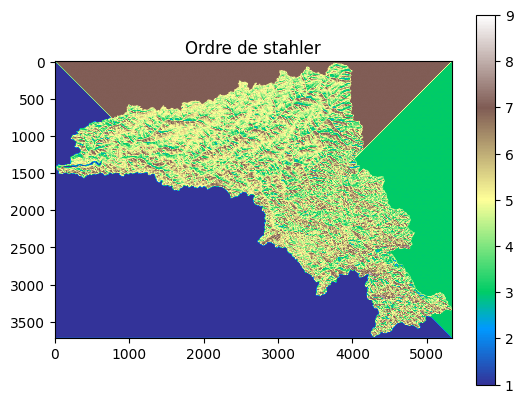

In [42]:
plt.imshow(array, cmap='terrain')
plt.colorbar()
plt.title("Ordre de stahler")
plt.show()

In [39]:
help(plt.imshow)

Help on function imshow in module matplotlib.pyplot:

imshow(X: 'ArrayLike | PIL.Image.Image', cmap: 'str | Colormap | None' = None, norm: 'str | Normalize | None' = None, *, aspect: "Literal['equal', 'auto'] | float | None" = None, interpolation: 'str | None' = None, alpha: 'float | ArrayLike | None' = None, vmin: 'float | None' = None, vmax: 'float | None' = None, origin: "Literal['upper', 'lower'] | None" = None, extent: 'tuple[float, float, float, float] | None' = None, interpolation_stage: "Literal['data', 'rgba'] | None" = None, filternorm: 'bool' = True, filterrad: 'float' = 4.0, resample: 'bool | None' = None, url: 'str | None' = None, data=None, **kwargs) -> 'AxesImage'
    Display data as an image, i.e., on a 2D regular raster.
    
    The input may either be actual RGB(A) data, or 2D scalar data, which
    will be rendered as a pseudocolor image. For displaying a grayscale
    image, set up the colormapping using the parameters
    ``cmap='gray', vmin=0, vmax=255``.
    
  

In [32]:
kedougou_strahler = strahler_value_point(strahlers, col, row)
kedougou_strahler

TypeError: cellvalue(): incompatible function arguments. The following argument types are supported:
    1. (map: pcraster._pcraster.Field, index: int) -> tuple
    2. (map: pcraster._pcraster.Field, row: int, col: int) -> tuple

Invoked with: <pcraster._pcraster.Field object at 0x7fb3714bbe70>, 2377, -2204